## DATA 512: Assignment 1: Data Curation 
- Created by: Libby Montague
- Date: 10/29/2017
- The intent of this script is to collect data on wikipedia articles about politicains and understand biases in the data. The country of origin of the polician and the population of the country are used to help understand potentail biases. 
- The script accesses the wikipedia ores API (please see the README for more information about the liscense for the data). Additionally, the script requires data from figshare and Population Research Bureau (see README for more information). 
- The first output of the script is wikipedia_ores_data_formatted.csv file with the complete merged data. Format of the file: 
    - country - the country of the politician 
    - article_name - the name of the wikipedia page (article)
    - revision_id - the wikipedia revision id of the article
    - article_quality - quality of the article using the ORES classification (FA, GA, B, C, Start, Stub)
    - population - population of the country 
- The second output of the script is a figure with four graphs showing the countries with the most and least political articles per capita and good quality political articles per capita. Good quality articles are defined as 'FA' or 'GA' scoring by ORES. 
- Copyright 2017 Elizabeth Montague elizam8@uw.edu, under MIT License

In [1]:
# import libraries
import requests
import json
import pandas as pd
import numpy as nm
import matplotlib.pyplot as plt
import copy
# store the working directory 
working_folder='{your working directory}'

## 1. Data
- The data are pulled from 3 sources:
    - Figshare: the wikipedia data on the politicans by country. The data should be downloaded from: https://figshare.com/articles/Untitled_Item/5513449. And the 'page_data.csv' file should be stored in the working folder. The column headers should be: page, country, rev_id.  
    - Population Research Bureau: the population data by country. The data should be downloaded from: http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14. The the 'Population Mid-2015.csv' file should be stored in the working directory. The column headers should be: Location, Location Type, TimeFrame, Data Type, Data, Footnotes. The only Location Type should be 'Country' and the only Data Type should be 'Number.'
    - ORES API: the 'rev_id' from the wikipedia data (Figshare) is used to query the ORES API for the article quality. The predicted score is the only value kept from the call. These results are then stored to a file in the working directory. The API call is slow, so this prevents the user from needing to call the API each time the script is run. 
- The data are then processed and stored in wikipedia_ores_data_formatted.csv. 

- Read in the data from the .csv files. 

In [2]:
# read in the .csv data files
# from figshare: https://figshare.com/articles/Untitled_Item/5513449
wikipedia_data=pd.read_csv(working_folder+'page_data.csv')
# from Population Research Bureau: http://www.prb.org/DataFinder/Topic/Rankings.aspx?ind=14
prb_data=pd.read_csv(working_folder+'Population Mid-2015.csv',skiprows=1,thousands=",")
# rename the columns to make merging easier
prb_data.columns=("country","Location Type","TimeFrame","Data Type","Data","Footnotes")

- Use the revision IDs from the wikipedia data (Figshare) to call the API. 
- First the revision IDs need to be broken up into sets of 50 for the batch query. There are > 47,000 revision IDs, so the API needs to be called 959 times. 
- Since the API call takes more than a couple mintues, there is a progress status printed. Additionally, the data are stored to a .csv file so that the user doesn't need to run the API call multiple times. 

In [3]:
# break up the revision IDs to be in the limit of 50 for the batch query 
# limit according to instructors of UW class 512
i=1
revids_all=list()
revids=""
for revid in wikipedia_data['rev_id']:
    if i == 1:
        revids=str(revid)
    else:
        if i % 50 == 0:
            revids_all.append(revids)
            revids=str(revid)
        else:
            revids=revids+"|"+str(revid)
    i=i+1
## subset for testing
revids_all_subset=list()
revids_all_subset.append(revids_all[1])
revids_all_subset.append(revids_all[2])
revids_all_subset.append(revids_all[3])

In [4]:
# adapted from template for assignment 2 for UW class 512 
# note: this takes a while to run therefore I recommend running once and saving to a .csv
endpoint = 'https://ores.wikimedia.org/v3/scores/enwiki/?models=wp10&revids={revid}'
headers = {'User-Agent' : '{insert you github webpage}', 'From' : '{insert your email}'}
i=0
for revids in revids_all:
    params = {
              'revid' : revids
              }
    api_call = requests.get(endpoint.format(**params))
    #print(endpoint.format(**params))
    response = api_call.json()
    revids_list=revids.split("|")
    for revid in revids_list:
        for k in response["enwiki"]["scores"][str(revid)]["wp10"]:
            if k == "score":
                new_row=[revid,response["enwiki"]["scores"][str(revid)]["wp10"]["score"]["prediction"]]
            else:
                print("error with "+str(revid)+", key = "+k)
        if i == 0:
            result=new_row
        else:
            result=nm.vstack((result,new_row))
    if i % 100 == 0:
        print('progress: '+str(i))
    i=i+1
# store the api call - so that the code above doesn't need to be read often
result=pd.DataFrame(result)
result.columns=("rev_id","score")
result.to_csv(working_folder+'wikipedia_ores_data_response.csv',header=True,index=False)

progress: 0
progress: 100
progress: 200
progress: 300
progress: 400
progress: 500
progress: 600
progress: 700
progress: 800
progress: 900
error with 807367030, key = error
error with 807367166, key = error


- Merge the data from the .csv files and the API call. 
- Write the final data file to a .csv file in the working directy. 

In [5]:
# merge the data
result['rev_id']=pd.to_numeric(result['rev_id'])
merged_result=pd.merge(result,wikipedia_data,on=['rev_id'],how="inner")
merged_result=pd.merge(merged_result,prb_data,on=['country'],how="inner")
# reorder the columns 
merged_result=merged_result[['country','page','rev_id','score','Data']]
# rename the columns 
merged_result.columns=('country','article_name','revision_id','article_quality','population')
# write the result to a .csv
merged_result.to_csv(working_folder+'wikipedia_ores_data_formatted.csv',header=True,index=False)

## 2. Analysis 
- Calculate the percent of articles per capita. 

In [6]:
country_result=pd.DataFrame(nm.vstack((merged_result['country'].value_counts().index,
                                       merged_result['country'].value_counts().values))).T
country_result.columns=('country','num_articles')
country_result=pd.merge(country_result,prb_data,on=['country'],how='inner')
country_result=country_result[['country','num_articles','Data']]
country_result.columns=('country','num_articles','population')
country_result['articles_by_population']=(country_result['num_articles']/pd.to_numeric(country_result['population']))*100000
country_result.index=country_result['country']

- Calculate the percent of quality articles ('FA' or 'GA') per total articles. 

In [36]:
total_articles_country=pd.DataFrame(nm.vstack((merged_result['country'].value_counts().index,
                                       merged_result['country'].value_counts().values))).T
total_articles_country.columns=('country','num_articles')
merged_result_quality=copy.deepcopy(merged_result)
merged_result_quality['article_quality']=merged_result_quality['article_quality'].map({'GA':'good','FA':'good'})
merged_result_quality=merged_result_quality.loc[merged_result_quality.article_quality=='good']
quality_articles_country=pd.DataFrame(nm.vstack((merged_result_quality['country'].value_counts().index,
                                       merged_result_quality['country'].value_counts().values))).T
quality_articles_country.columns=('country','num_quality_articles')
quality_country_result=pd.merge(quality_articles_country,total_articles_country,on=['country'],how='inner')
quality_country_result['per_quality_articles']=(quality_country_result['num_quality_articles']/
                                                quality_country_result['num_articles'])*100
quality_country_result.index=quality_country_result['country']

## 3. Visualization 
- Visualize the data based on the top and bottom countries according to the articles per capita and the quality articles per total articles. 

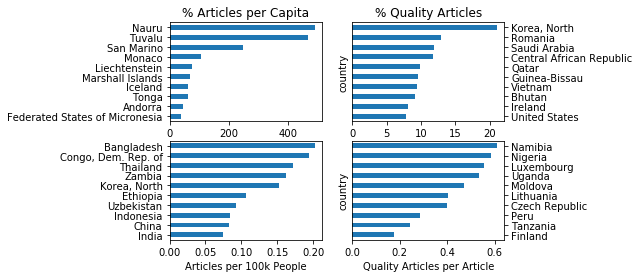

In [41]:
## plot within the jupyter notebook
%matplotlib inline
figure,axis=plt.subplots(nrows=2,ncols=2)

data1=country_result.sort_values(by=['articles_by_population'])[['articles_by_population']][:10]
fig1=data1.plot(kind='barh',ax=axis[1,0],legend=False)
fig1.set_ylabel('')
fig1.set_xlabel('Articles per 100k People')

data2=country_result.sort_values(by=['articles_by_population'],ascending=False)[['articles_by_population']][:10]
data2=data2.sort_values(by=['articles_by_population'],ascending=True)[['articles_by_population']]
fig2=data2.plot(kind='barh',ax=axis[0,0],legend=False)
fig2.set_ylabel('')
fig2.set_title('% Articles per Capita')

data3=quality_country_result.sort_values(by=['per_quality_articles'],ascending=False)[['per_quality_articles']][:10]
data3=data3.sort_values(by=['per_quality_articles'],ascending=True)[['per_quality_articles']]
fig3=data3.plot(kind='barh',ax=axis[0,1],legend=False)
fig3.set_title('% Quality Articles')
fig3.yaxis.tick_right()

data4=quality_country_result.sort_values(by=['per_quality_articles'],ascending=True)[['per_quality_articles']][:10]
fig4=data4.plot(kind='barh',ax=axis[1,1],legend=False)
fig4.set_xlabel('Quality Articles per Article')
fig4.yaxis.tick_right()

figure.savefig(working_folder+'wikipedia_quality_by_country.png',bbox_inches='tight')

plt.show()

## 4. Reflection

    One bias that is immediately clear has to do with North Korea. North Korea has the highest number of quality articles per total articles. Using this point alone, one could assume that North Korea has more quality articles then other countries. But we also see that North Korea has one of the lowest rates of political articles per capita. Therefore, the conclusion may be instead that, North Korea has less articles are political figures, but there is a higher number of quality articles. By considering the number of articles per capita, then we start to see a clearer picture about the trends behind the number of quality articles per non-quality articles. 

    Another bias that is clear is the larger differnce between the 2 countries with the largest articles per capita. The top two countries have between 0.4-0.5% of the articles per capita, while the 3rd country has about half as many. These two countries have the smallest population in the dataset. Therefore the reason that these countries have such a large percentage compared to other countries should be investiaged, is it simply because thier population is so small? 
   
    There are other biases that this research does not investigate. For instance, these are from the english wikipedia site, what is the prevelance of these countries in the news in english speaking countries? Additionally, what is the nationality of the authors? Are some of the countries not as well represented because there are less editors who write about these countries? We also know that this only goes 2 levels down in the heirarchy for the politicians, are some countries' polician pages structured differently? 